# Matrix factorization

En esta clase trabajaremos con un dataset que contiene reviews de películas.

El objetivo será recomendar películas nuevas a los usuarios (el usuario no debe haberla visto anteriormente).

El principal objetivo de este notebook es aprender a utilizar algunas herramientas y métodos para construir sistemas de recomendación. Trabajaremos con un set de datos muy chico por lo que los resultados que obtendremos no serán muy buenos. Luego trabajaremos con datasets más reales (y grandes) con los cuales podremos obtener resultados mucho más llamativos.

In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip /content/ml-latest-small.zip -d ./

--2021-12-22 22:14:08--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  4.63MB/s    in 0.2s    

2021-12-22 22:14:08 (4.63 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  /content/ml-latest-small.zip
   creating: ./ml-latest-small/
  inflating: ./ml-latest-small/links.csv  
  inflating: ./ml-latest-small/tags.csv  
  inflating: ./ml-latest-small/ratings.csv  
  inflating: ./ml-latest-small/README.txt  
  inflating: ./ml-latest-small/movies.csv  


In [ ]:
import pandas as pd

En el primer dataset tenemos los nombres de las películas con su género.

In [ ]:
movies = pd.read_csv("/content/ml-latest-small/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


En el siguiente, tenemos lo que más nos interesa para un filtro colaborativo: Las interacciones entre usuarios y películas

In [ ]:
ratings = pd.read_csv("/content/ml-latest-small/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
ratings.shape

(100836, 4)

In [ ]:
ratings.userId.nunique()

610

Tenemos 610 usuarios

Podemos ver que tenemos una columna timestamp. Este tipo de datos se puede convertir a una fecha de la siguiente manera:

In [ ]:
from datetime import datetime
ts = int('1593850294')

print(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))

2020-07-04 08:11:34


O tomando solamente la fecha (sin horario):

In [ ]:
print(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d'))

2017-05-03


Convertir los timestamps a fecha (sin hora):

In [ ]:
ratings["timestamp"] = ratings["timestamp"].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d'))

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30
1,1,3,4.0,2000-07-30
2,1,6,4.0,2000-07-30
3,1,47,5.0,2000-07-30
4,1,50,5.0,2000-07-30


Las siguientes celdas cambian el tipo de dato de la columna timestamp para que sea más simple trabajar con fechas

In [ ]:
ratings.timestamp.dtype

dtype('O')

In [ ]:
ratings["timestamp"] = pd.to_datetime(ratings['timestamp'], format='%Y/%m/%d')

In [ ]:
ratings.timestamp.dtype

dtype('<M8[ns]')

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30
1,1,3,4.0,2000-07-30
2,1,6,4.0,2000-07-30
3,1,47,5.0,2000-07-30
4,1,50,5.0,2000-07-30


¿En qué intervalo de fechas tenemos reviews? (fecha minima y maxima)

In [ ]:
ratings.timestamp.min()

Timestamp('1996-03-29 00:00:00')

In [ ]:
ratings.timestamp.max()

Timestamp('2018-09-24 00:00:00')

Ploteamos la cantidad de reviews por año:

In [ ]:
plot_df = ratings.copy()
plot_df["year"] = ratings.timestamp.dt.year
plot_df = plot_df.groupby("year", as_index=False).count()[["year", "userId"]]
plot_df.columns = ["year", "reviews_count"]
plot_df.head()

,year,reviews_count
0,1996,6040
1,1997,1916
2,1998,507
3,1999,2439
4,2000,10061


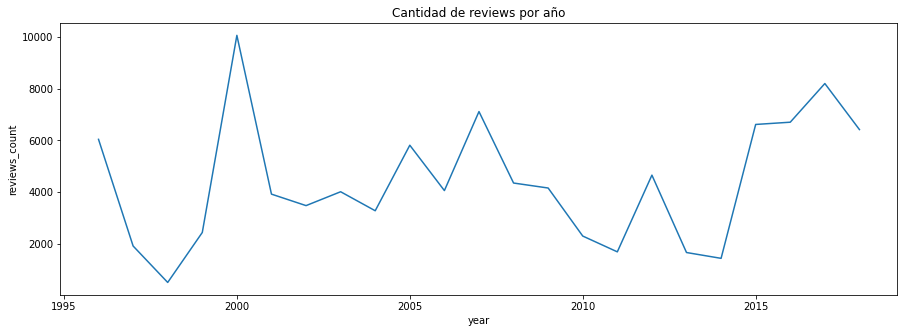

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,5))
sns.lineplot(x=plot_df.year, y=plot_df.reviews_count)
plt.title("Cantidad de reviews por año")
plt.show()

Ahora vamos a dividir el dataset en train y test.

En este caso, tenemos datos desde 1996 hasta 2018, pero no utilizaremos todos estos años.

Vamos a entrenar nuestro modelo con todas las interacciones que ocurrieron entre el 1ro de enero de 2017 y el 1ro de enero de 2018. En base a esto buscaremos predecir las películas que los usuarios van a ver en el resto de 2018.

Para comparar la columna timestamp contra una fecha, pueden utilizar el siguiente objeto: `datetime(year=..., month=..., day=...)`

Por ejemplo: `datetime(year=2015, month=10, day=1)`

Dividir el set de interacciones en train y test.

In [ ]:
train = ratings[(ratings.timestamp >= datetime(year=2017, month=1, day=1)) &
                (ratings.timestamp < datetime(year=2018, month=1, day=1))]
train.head()

,userId,movieId,rating,timestamp
1434,15,1,2.5,2017-11-13
1436,15,47,3.5,2017-11-13
1440,15,260,5.0,2017-11-13
1441,15,293,3.0,2017-11-13
1442,15,296,4.0,2017-11-13


In [ ]:
train.shape

(8198, 4)

In [ ]:
train.userId.nunique()

58

In [ ]:
test = ratings[ratings.timestamp >= datetime(year=2018, month=1, day=1)]
test.head()

,userId,movieId,rating,timestamp
1839,18,913,4.0,2018-02-01
1852,18,1193,4.5,2018-02-03
1980,18,5120,4.5,2018-01-15
2012,18,6787,4.0,2018-08-11
2053,18,27878,4.5,2018-05-12


In [ ]:
test.shape

(6418, 4)

In [ ]:
test.userId.nunique()

49

Podemos tener un problema...

¿Qué pasa si tenemos un usuario que aparece en test pero no en train? ¿Qué le recomendamos?

COLD START...

Vamos a ver si tenemos este problema. Buscar usuarios que estén en el set de test y NO estén en el de train (máscaras..)

In [ ]:
test[~test.userId.isin(train.userId.unique())].userId.nunique()

34

Ahora que tenemos los sets divididos en train y test, vamos a armar la matriz de interacciones.

Para esto necesitamos únicamente 3 columnas de las 4 que tiene el dataset de interacciones. ¿Cuáles son?


In [ ]:
matrix_columns = ["userId", "movieId", "rating"]

In [ ]:
interactions = train[matrix_columns]
interactions.head()

,userId,movieId,rating
1434,15,1,2.5
1436,15,47,3.5
1440,15,260,5.0
1441,15,293,3.0
1442,15,296,4.0


Para armar la matriz utilizaremos una pivot table de pandas.

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html

In [ ]:
interactions_matrix = interactions.pivot(index="userId", columns="movieId", values="rating")

In [ ]:
interactions_matrix.head()

movieId,1,2,3,5,6,7,9,10,11,12,13,16,17,18,19,20,21,23,24,25,26,29,31,32,34,36,39,41,42,44,45,47,48,50,52,60,62,65,69,70,...,171011,171023,171759,171763,171765,172013,172233,172461,172497,172881,172887,173145,173197,173209,173291,173307,173751,173941,174053,174055,174737,175303,175485,175569,175661,175705,175707,175743,175781,176101,176371,176389,176413,176415,176579,176751,179073,179819,180777,182823
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,NaN
21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Van a ver una matriz con muchos NaN.

¿Qué significan los NaN?

In [ ]:
interactions_matrix = interactions_matrix.fillna(0)

In [ ]:
interactions_matrix.head()

movieId,1,2,3,5,6,7,9,10,11,12,13,16,17,18,19,20,21,23,24,25,26,29,31,32,34,36,39,41,42,44,45,47,48,50,52,60,62,65,69,70,...,171011,171023,171759,171763,171765,172013,172233,172461,172497,172881,172887,173145,173197,173209,173291,173307,173751,173941,174053,174055,174737,175303,175485,175569,175661,175705,175707,175743,175781,176101,176371,176389,176413,176415,176579,176751,179073,179819,180777,182823
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


¿Cuántas filas y columnas tiene?

In [ ]:
interactions_matrix.shape

(58, 3309)

En este caso, al ser un dataset chico no tenemos muchos usuarios y películas. La matriz es relativamente chica.

En general (con datasets que trabajaremos en la entrega por ejemplo) vamos a obtener matrices muy grandes y dispersas (sparse).

Por esta razón, vamos a transformar la matriz a csr matrix (compressed sparse row): https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html



In [ ]:
from scipy.sparse import csr_matrix

In [ ]:
interactions_matrix_csr = csr_matrix(interactions_matrix.values)

In [ ]:
interactions_matrix_csr

<58x3309 sparse matrix of type '<class 'numpy.float64'>'
	with 8198 stored elements in Compressed Sparse Row format>

La siguiente celda generará un diccionario que nos servirá como índice más adelante.

Tiene como keys el id de cada usuario y como valor el indice (número de fila en la matriz)

In [ ]:
user_ids = list(interactions_matrix.index)
user_dict = {}
counter = 0
for i in user_ids:
    user_dict[i] = counter
    counter += 1

In [ ]:
user_dict

{15: 0,
 18: 1,
 21: 2,
 30: 3,
 47: 4,
 49: 5,
 50: 6,
 65: 7,
 67: 8,
 106: 9,
 112: 10,
 114: 11,
 119: 12,
 125: 13,
 141: 14,
 154: 15,
 159: 16,
 190: 17,
 210: 18,
 212: 19,
 249: 20,
 252: 21,
 279: 22,
 282: 23,
 292: 24,
 305: 25,
 318: 26,
 328: 27,
 339: 28,
 341: 29,
 352: 30,
 363: 31,
 365: 32,
 380: 33,
 400: 34,
 401: 35,
 408: 36,
 413: 37,
 414: 38,
 433: 39,
 443: 40,
 448: 41,
 461: 42,
 462: 43,
 471: 44,
 475: 45,
 515: 46,
 517: 47,
 523: 48,
 526: 49,
 534: 50,
 548: 51,
 550: 52,
 551: 53,
 561: 54,
 599: 55,
 601: 56,
 610: 57}

# Modelo

Ya tenemos la matriz lista para entrenar el modelo.

Utilizaremos la librería LFM (light fm). https://making.lyst.com/lightfm/docs/home.html

Existen otras librerías como "surprise" (muy lenta).

Primero que nada instalamos la librería y definimos nuestro modelo:



In [ ]:
pip install lightfm

     |████████████████████████████████| 310 kB 5.3 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705346 sha256=5392ee08bd9386e56529a307b854237bcac16280c2c78940bcde07e10d63dad8
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3bd3413d65f03aa452190b00898b680b10028a1021914
Successfully built lightfm


In [ ]:
from lightfm import LightFM

model = LightFM(no_components=3, random_state=100, learning_rate=0.03)

Ahora model tiene el método .fit igual que todas las librerías que vimos hasta ahora.

Entrenar el modelo con la matriz csr por 10 epochs:

In [ ]:
%%time
model = model.fit(interactions_matrix_csr, epochs=10)

CPU times: user 23.8 ms, sys: 4 µs, total: 23.8 ms
Wall time: 23.8 ms


In [ ]:
model

Ahora podríamos generar recomendaciones simplemente haciendo:

In [ ]:
import numpy as np
user_x = user_dict[18]
n_users, n_items = interactions_matrix.shape
item_ids = np.arange(n_items)
#ACA GENERAMOS PREDICCIONES
preds = model.predict(user_ids=user_x, item_ids = item_ids)

Este array que obtenemos son los scores que le da el modelo a cada item para el usuario 18. Podemos ordenarlo y obtener las mejores recomendaciones

In [ ]:
scores = pd.Series(preds)
scores.index = interactions_matrix.columns
recomms_18 = list(pd.Series(scores.sort_values(ascending=False).index))[:10] #obtenemos las primeras 10

Recomendaciones para el usuario 18:

In [ ]:
recomms_18

[318, 356, 2959, 79132, 2571, 296, 122904, 260, 60069, 168252]

Al ser un dataset muy chico, lo más probable es que terminemos recomendando contenidos populares a todos los usuarios.

Como dijimos anteriormente, el objetivo es que comprendamos como utilizar las herramientas con un dataset simple para luego aplicarlo a un dataset más real.

¿Qué había visto el usuario 18 (en el set de train)?

In [ ]:
train[(train.userId==18)].movieId.unique()

array([   555,   1095,   1227,   1245,   2184,   2490,   3253,   3896,
         4007,   4383,   6300,   7018,   7753,   7843,  26614,  32460,
        44555,  64197,  71108,  90600,  91485,  96655, 102903, 118900,
       122918, 122926, 128620, 142488, 148626, 157108, 157110, 158238,
       158972, 159093, 161582, 162606, 166635, 168252, 171023, 176101,
       180777])

Ya había visto alguno de los contenidos que le estamos recomendando?

In [ ]:
train[(train.userId==18) & (train.movieId.isin(recomms_18))].movieId.unique()

array([168252])

El usuario ya había visto la película 168252.

Deberíamos filtrarla de las recomendaciones ya que no queremos recomendar contenido visto anteriormente.

Para esto:

1) Obtener listado de películas vistas (en train) por el usuario 18

In [ ]:
user_18_watched = train[train.userId == 18].movieId.unique()

2) Filtrar esas películas de la lista de recomendaciones

In [ ]:
recomms_18 = [rec for rec in recomms_18 if rec not in user_18_watched]

In [ ]:
recomms_18

[318, 356, 2959, 79132, 2571, 296, 122904, 260, 60069]

En un sistema de filtro colaborativo siempre puede pasar que el modelo nos recomiende algún item que el usuario ya vió. También puede pasar que nos recomiende algún item que no queremos recomendar por alguna razon. Puede ser alguna restricción del negocio, un contenido que no estará disponible más adelante, etc.

Por todo esto, es importante siempre pedirle al modelo que nos genere más recomendaciones de las que queremos mostrarle al usuario. Por ejemplo, si a nuestros usuarios queremos mostrarles 10 recomendaciones, al sistema le podríamos pedir que nos recomiende 50. Luego, sobre estas 50 recomms aplicamos filtros (contenidos ya vistos, contenidos que no queremos recomendar, etc) y podrían quedarnos por ejemplo unas 30 recomendaciones. De estas 30 tomamos las mejores 10 y nos aseguramos de que siempre le vamos a estar recomendando 10 items al usuario.

Si nosotros le pedimos al modelo únicamente 10 recomendaciones, luego de aplicar los filtros nos pueden quedar pocas (o ninguna) recomm.



**COLD START**

¿Qué pasa con los usuarios que no tenemos en el set de train?

Podemos recomendarles por ejemplo, los contenidos más populares.

Para esto, basandonos en el set de train vamos a generar un dataset ordenado por popularidad.

Generar un dataset ordenado por popularidad (cantidad de usuarios que le dieron un rating, sin importar el rating).

In [ ]:
train.head()

,userId,movieId,rating,timestamp
1434,15,1,2.5,2017-11-13
1436,15,47,3.5,2017-11-13
1440,15,260,5.0,2017-11-13
1441,15,293,3.0,2017-11-13
1442,15,296,4.0,2017-11-13


In [ ]:
train.groupby("movieId", as_index=False).agg({"userId":"nunique"})

,movieId,userId
0,1,15
1,2,7
2,3,1
3,5,1
4,6,6
...,...,...
3304,176751,1
3305,179073,1
3306,179819,3
3307,180777,1


In [ ]:
popularity_df = train.groupby("movieId", as_index=False).agg({"userId":"nunique"}).sort_values(by="userId", ascending=False)

popularity_df.columns=["movieId", "popularity"]
popularity_df.head()

,movieId,popularity
112,318,31
130,356,28
2458,79132,25
791,2571,22
894,2959,22


Obtener una lista con los 10 contenidos más populares

In [ ]:
popular_content = popularity_df.movieId.values[:10]

In [ ]:
popularity_df.head(10).movieId.values

array([   318,    356,  79132,   2571,   2959,  60069,    260,    296,
       122904,   4993])

In [ ]:
popular_content

array([   318,    356,  79132,   2571,   2959,  60069,    260,    296,
       122904,   4993])

Ahora basándonos en el ejemplo anterior, vamos a generar 10 recomendaciones para todos los usuarios.

Debemos tener en cuenta:

- Filtrar contenidos que el usuario vio anteriormente
- Si el usuario no está en el set de train, recomendarle los 10 contenidos más populares


In [ ]:
interactions_matrix.head()

movieId,1,2,3,5,6,7,9,10,11,12,13,16,17,18,19,20,21,23,24,25,26,29,31,32,34,36,39,41,42,44,45,47,48,50,52,60,62,65,69,70,...,171011,171023,171759,171763,171765,172013,172233,172461,172497,172881,172887,173145,173197,173209,173291,173307,173751,173941,174053,174055,174737,175303,175485,175569,175661,175705,175707,175743,175781,176101,176371,176389,176413,176415,176579,176751,179073,179819,180777,182823
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
interactions_matrix.shape

(58, 3309)

In [ ]:
interactions_matrix.index

Int64Index([ 15,  18,  21,  30,  47,  49,  50,  65,  67, 106, 112, 114, 119,
            125, 141, 154, 159, 190, 210, 212, 249, 252, 279, 282, 292, 305,
            318, 328, 339, 341, 352, 363, 365, 380, 400, 401, 408, 413, 414,
            433, 443, 448, 461, 462, 471, 475, 515, 517, 523, 526, 534, 548,
            550, 551, 561, 599, 601, 610],
           dtype='int64', name='userId')

In [ ]:
from tqdm import tqdm

#definimos dict donde vamos a ir almacenando las recomendaciones
recomms_dict = {
    'user_id': [],
    'recomms': []
}

#obtenemos cantidad de usuarios y cantidad de items
n_users, n_items = interactions_matrix.shape
item_ids = np.arange(n_items)

#por cada usuario del dataset de test, generamos recomendaciones
for user in tqdm(test.userId.unique()):

    if user in list(interactions_matrix.index):
      # Si el usuario esta en train, no es cold start. Usamos el modelo para recomendar
      user_x = user_dict[user] #buscamos el indice del usuario en la matriz (transformamos id a indice)

      preds = model.predict(user_ids=user_x, item_ids = item_ids)

      scores = pd.Series(preds)
      scores.index = interactions_matrix.columns
      scores = list(pd.Series(scores.sort_values(ascending=False).index))[:50]

      watched_contents = train[train.userId == user].movieId.unique()


      recomms = [x for x in scores if x not in watched_contents][:10]

      # Guardamos las recomendaciones en el diccionario
      recomms_dict['user_id'].append(user)
      recomms_dict['recomms'].append(scores)

    # En este else trataremos a los usuarios que no están en la matriz (cold start)
    else:
      recomms_dict['user_id'].append(user)
      # Les recomendamos contenido popular
      recomms_dict['recomms'].append(popular_content)




100%|██████████| 49/49 [00:00<00:00, 1053.80it/s]


Ya tenemos las recomendaciones. Convertimos el dict a dataframe:

In [ ]:
recomms_df = pd.DataFrame(recomms_dict)
recomms_df

,user_id,recomms
0,18,"[318, 356, 2959, 79132, 2571, 296, 122904, 260..."
1,25,"[318, 356, 79132, 2571, 2959, 60069, 260, 296,..."
2,50,"[318, 356, 79132, 2571, 2959, 122904, 60069, 1..."
3,62,"[318, 356, 79132, 2571, 2959, 60069, 260, 296,..."
4,68,"[318, 356, 79132, 2571, 2959, 60069, 260, 296,..."
5,77,"[318, 356, 79132, 2571, 2959, 60069, 260, 296,..."
6,89,"[318, 356, 79132, 2571, 2959, 60069, 260, 296,..."
7,98,"[318, 356, 79132, 2571, 2959, 60069, 260, 296,..."
8,103,"[318, 356, 79132, 2571, 2959, 60069, 260, 296,..."
9,105,"[318, 356, 79132, 2571, 2959, 60069, 260, 296,..."


Vemos que nuestro sistema no es muy bueno ya que a todos les recomienda en primer lugar el contenido 318 (el más popular). Además, a la mayoría de los usuarios les estamos dando reocmendaciones de cold start ya que el dataset es pequeño.

Este notebook les servirá como una buena guía para implementar sistemas de recomendación con otros datasets (por ejemplo, el de la entrega de este sprint).

Tengan en cuenta:

- No siempre los ratings van a estar explícitos como en este caso. Si no estuviesen explícitos, tienen muchas opciones para completar la matriz. Pueden simplemente completarla con 1s y 0s (indicando si el usuario vió o no vió el contenido). Si están trabajando con productos, pueden utilizar la cantidad de veces que el usuario compró el producto. Todo lo que se les ocurra para obtener una medida de que tan fuerte es la relación entre usuario-item es válido.

- Siempre recuerden filtrar recomendaciones que no les interesa generar. Recuerden que en un sistema de recomendación siempre vamos a tener una cantidad de espacio limitada para mostrar recomendaciones. Si tenemos por ejemplo solo 3 lugares, las 3 recomendaciones que hagamos deben ser muy buenas para que el sistema funcione. Si de 3 recomendaciones, le mostramos al usuario 2 películas que ya vió, nuestro sistema no tendrá sentido.
De la misma forma si le recomendamos por ejemplo películas que estaban disponibles en nuestro sistema al momentro de entrenar el modelo, pero al momento de mostrar la recomendación ya no están, tampoco tiene sentido.
